In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import iso_funcs as iso

In [2]:
outf = "test/"

emc = pd.read_csv("../" + outf + "dataframes/final/He3_H2.csv",index_col=0)
KP = pd.read_csv('KP_super.csv')
f2r_tong = pd.read_csv('f2v.csv')
dp_np = pd.read_csv("dp_np.csv")
f2r_mike = pd.read_csv('mike_f2r.csv')
h3 = pd.read_csv('H3_D2_Tyler.csv')

norm=2.8
h3norm = 0

In [3]:
KP.query('x>=0.2 & x<=0.4',inplace=True)

c = np.polyfit(KP['x'],KP['R'],5)
h3c = np.polyfit(KP['x'],KP['RH3'],5)

def KP_fit(x):
    return np.polyval(c,x)

def H3KP_fit(x):
    return np.polyval(h3c,x)

In [4]:
#Calculate F2n/F2p from the Helium-3 EMC Ratio
emc.Ratio = emc.Ratio*((norm/100) + 1)
emc['F2n_F2p'] = (emc['Ratio'] - (2 * KP_fit(emc['BinCenter']))) / (KP_fit(emc['BinCenter']) - emc['Ratio'])

#Calculate the uncertainty of this extraction
#Uncertainty from the Helium-3 EMC Ratio
emc['F2n_F2p_Error'] = ((emc.RelSyst**2 + emc.RelPre**2)**(1/2)) * (KP_fit(emc.BinCenter) / ((KP_fit(emc.BinCenter) - emc.Ratio)**2))

#display(emc)

h3.ratio = h3.ratio*((h3norm/100) + 1)
h3['F2n_F2p'] = (h3['ratio'] - (H3KP_fit(h3['Bin_Center']))) / ((2*H3KP_fit(h3['Bin_Center'])) - h3['ratio'])
h3['f2err'] = (h3.error*H3KP_fit(h3['Bin_Center']))/(((2*H3KP_fit(h3['Bin_Center']))-h3.ratio)**2)


Now to determine the normalization for He3 using the F2n/F2p extracted from H2/H1 (which agrees with world data) and F2n/F2p extracted from He3/H2 (which is inconsistent with the H2/H1 extraction).

In [5]:
#f2r = emc.query('BinCenter>=0.255 & BinCenter<=0.345')
#f2r = emc.query('(BinCenter>=0.255 & BinCenter<=0.3) | BinCenter==0.345')
f2r = emc.query('(BinCenter>=0.255 & BinCenter<=0.315)')

#Uncertainty from the KP model of the Super Ratio
#I only have the uncertainty from a select number of points, so this will be applied manually
f2r.F2n_F2p_Error.iat[0] = ((f2r.iloc[0].F2n_F2p_Error)**2 + (((0.0024 * KP_fit(f2r.iloc[0].BinCenter))**2) * ((f2r.iloc[0].Ratio/((KP_fit(f2r.iloc[0].BinCenter) - f2r.iloc[0].Ratio)**2))**2)))**(1./2.)
f2r.F2n_F2p_Error.iat[1] = ((f2r.iloc[1].F2n_F2p_Error)**2 + (((0.0028 * KP_fit(f2r.iloc[1].BinCenter))**2) * ((f2r.iloc[1].Ratio/((KP_fit(f2r.iloc[1].BinCenter) - f2r.iloc[1].Ratio)**2))**2)))**(1./2.)
f2r.F2n_F2p_Error.iat[2] = ((f2r.iloc[2].F2n_F2p_Error)**2 + (((0.0033 * KP_fit(f2r.iloc[2].BinCenter))**2) * ((f2r.iloc[2].Ratio/((KP_fit(f2r.iloc[2].BinCenter) - f2r.iloc[2].Ratio)**2))**2)))**(1./2.)
#f2r.F2n_F2p_Error.iat[3] = ((f2r.iloc[3].F2n_F2p_Error)**2 + (((0.0036 * KP_fit(f2r.iloc[3].BinCenter))**2) * ((f2r.iloc[3].Ratio/((KP_fit(f2r.iloc[3].BinCenter) - f2r.iloc[3].Ratio)**2))**2)))**(1./2.)
#f2r.F2n_F2p_Error.iat[2] = ((f2r.iloc[2].F2n_F2p_Error)**2 + (((0.0036 * KP_fit(f2r.iloc[2].BinCenter))**2) * ((f2r.iloc[2].Ratio/((KP_fit(f2r.iloc[2].BinCenter) - f2r.iloc[2].Ratio)**2))**2)))**(1./2.)

#display(f2r)

#f2r_a3 = f2r_tong.query('BinCenter>=0.255 & BinCenter<=0.345')
#f2r_a3 = f2r_tong.query('(BinCenter>=0.255 & BinCenter<=0.3) | BinCenter==0.345')
f2r_a3 = f2r_tong.query('BinCenter>=0.255 & BinCenter<=0.315')

#dp_np.query('BinCenter>=0.255 & BinCenter<=0.345',inplace=True)
#dp_np.query('(BinCenter>=0.255 & BinCenter<=0.3) | BinCenter==0.345',inplace=True)
dp_np.query('(BinCenter>=0.255 & BinCenter<=0.315)',inplace=True)

h3.query('Bin_Center>=0.255 & Bin_Center<=0.315',inplace=True)
#h3.query('Bin_Center>=0.255 & Bin_Center<=0.345',inplace=True)
#h3.query('(Bin_Center>=0.255 & Bin_Center<=0.3) | Bin_Center==0.345',inplace=True)

In [6]:
#Calculate Chi^2 for comparing He3/H2 extraction to H2/H1 extraction

f2r = f2r.merge(dp_np,on='BinCenter')
f2r = f2r.merge(f2r_a3,on='BinCenter')
#display(f2r)
Xi2 = f2r.apply(lambda x: ((x.F2n_F2p - iso.f2np(x.BinCenter))**2)/(x.F2n_F2p_Error**2) ,axis=1).sum()
print(Xi2)

Xi2 = f2r.apply(lambda x: ((x.F2n_F2p - x.f2r)**2)/(x.F2n_F2p_Error**2) ,axis=1).sum()
print(Xi2)

Chi2 = f2r.apply(lambda x: ((x.F2n_F2p - x.f2np)**2)/(x.F2n_F2p_Error**2),axis=1).sum()
print(Chi2)

1.940110866720381
0.5122049484303606
1.9056751124738116


In [7]:
h3.rename(columns={"Bin_Center" : "BinCenter"},inplace=True)
h3 = h3.merge(dp_np,on="BinCenter")
h3 = h3.merge(f2r_a3,on='BinCenter')


H3Chi2 = h3.apply(lambda x: ((x.F2n_F2p - iso.f2np(x.BinCenter))**2)/(x.f2err**2),axis=1).sum()
print(H3Chi2)

H3Chi2 = h3.apply(lambda x: ((x.F2n_F2p - x.f2r)**2)/(x.f2err**2),axis=1).sum()
print(H3Chi2)

H3Chi2 = h3.apply(lambda x: ((x.F2n_F2p - x.f2np)**2)/(x.f2err**2),axis=1).sum()
print(H3Chi2)

0.12471143117776572
0.9034463447018707
0.24953894156148554


Text(0, 0.5, 'Extracted $F_2^n/F_2^p$')

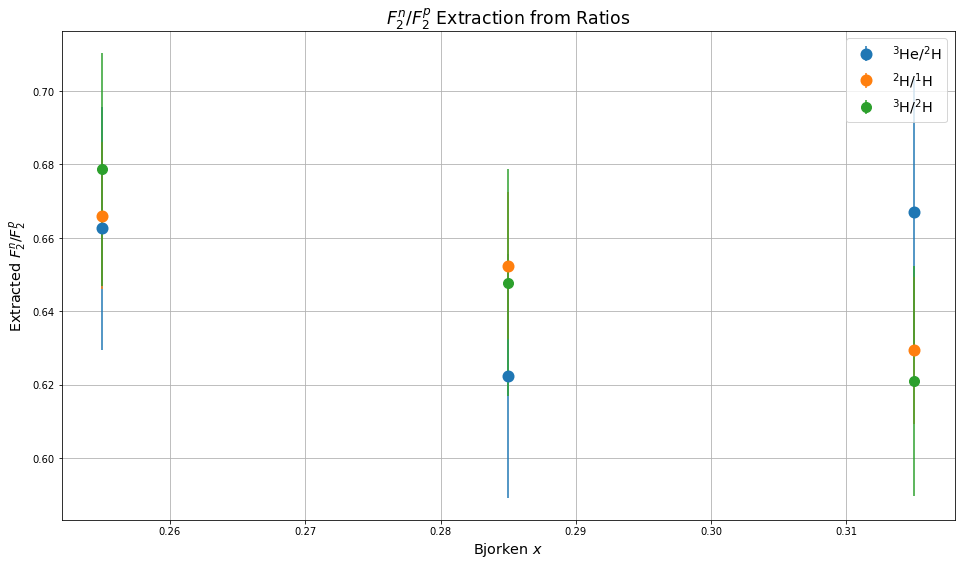

In [8]:
plt.figure(figsize=(16,9))
plt.errorbar(f2r.BinCenter,f2r.F2n_F2p,f2r.F2n_F2p_Error,fmt='o',label='$^3$He/$^2$H',ms=10,mew=2)
#plt.errorbar(f2r_a3.BinCenter,f2r_a3.f2r,f2r_a3.f2r_error,fmt='o',fillstyle='none',label='H3/He3',ms=10,mew=2)
#plt.errorbar(f2r.BinCenter,iso.f2np(f2r.BinCenter),f2r.BinCenter.apply(iso.f2np_err),fmt='o',label='$^3$H/$^3$He Fit',ms=10,mew=2)
#plt.errorbar(f2r_mike.Bin_Center,f2r_mike.F2n_F2p,f2r_mike.All_Error,fmt='o',fillstyle='none',label='Mike $^3$H/$^2$H',ms=10,mew=2)
plt.errorbar(f2r.BinCenter,f2r.f2np,f2r.f2np_err,fmt='o',label='$^2$H/$^1$H',ms=10,mew=2)
plt.errorbar(h3.BinCenter,h3.F2n_F2p,h3.f2err,fmt='o',label='$^3$H/$^2$H',ms=10)
plt.legend(fontsize='x-large')
plt.grid()
#plt.gca().set(ylim=(0.5,0.85))
plt.title('$F_2^n/F_2^p$ Extraction from Ratios',fontsize='xx-large')
plt.xlabel('Bjorken $x$',fontsize='x-large')
plt.ylabel('Extracted $F_2^n/F_2^p$',fontsize='x-large')
#plt.savefig('f2r_2_4_norm.eps')